In [1]:
#hide
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#hide
%load_ext autoreload
%autoreload 2

%matplotlib inline
%cd /content/gdrive/My Drive/Colab Notebooks

/content/gdrive/My Drive/Colab Notebooks


In [ ]:
#hide
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [ ]:
#hide
# !git clone https://github.com/prajwal-suresh13/dl_lib.git

In [ ]:
from dl_lib.core.all import *
from dl_lib.cyclegan.cycleganloss import *
from dl_lib.cyclegan.datadl import *
from dl_lib.cyclegan.cycleganmodel import *

In [ ]:
__all__ = 'SmoothenValue CycleGANTrainer ShowCycleGANImgsCallback BatchTransformXTupleCallback BatchTransformXYCallback LoadPretrainedModelCallback SaveCycleGANModelCallback LoadCycleGANModelCallback cyclegan_learner pretrain_cyclegan_generator'.split(" ")

# CycleGAN Trainer

In [ ]:
class SmoothenValue():
    def __init__(self, beta):
        self.beta, self.n, self.mov_avg = beta,0,0.


    def add_value(self,val):
        self.n += 1
        self.mov_avg = lin_comb(self.beta, self.mov_avg, val)
        self.smooth = self.mov_avg/(1-self.beta**self.n)

In [ ]:
class CycleGANTrainer(Callback):
    _order = -20

    def _set_trainable(self, D_A=False, D_B = False):
        gen = (not D_A) and (not D_B)

        def set_requires_grad(m,req):
            for p in m.parameters(): p.requires_grad_(req)

        set_requires_grad(self.learner.model.G_A, gen)
        set_requires_grad(self.learner.model.G_B, gen)
        set_requires_grad(self.learner.model.D_A, D_A)
        set_requires_grad(self.learner.model.D_B, D_B)

        if not gen:
            self.opt_D_A.hypers = self.opt.hypers
            self.opt_D_B.hypers = self.opt.hypers

    def before_fit(self):
        self.G_A, self.G_B = self.learner.model.G_A, self.learner.model.G_B
        self.D_A, self.D_B = self.learner.model.D_A, self.learner.model.D_B
        self.crit = self.learner.loss_func.crit

        if not getattr(self,'opt_G',None):
            self.opt_G = self.learner.opt_func(self.learner.splitter(nn.Sequential(*flatten_model(self.G_A),*flatten_model(self.G_B))), lr=self.learner.lr)
            
        else:
            self.opt_G.hypers = self.learner.opt.hypers
        
        if not getattr(self, 'opt_D_A',None):
            self.opt_D_A = self.learner.opt_func(self.learner.splitter(nn.Sequential(*flatten_model(self.D_A))), lr=self.learner.lr)
        else:
            self.opt_D_A.hypers = self.learner.opt.hypers

        if not getattr(self,'opt_D_B',None):
            self.opt_D_B = self.learner.opt_func(self.learner.splitter(nn.Sequential(*flatten_model(self.D_B))), lr=self.learner.lr)
        else:
            self.opt_D_B.hypers = self.learner.opt.hypers

        self.learner.opt = self.opt_G

        if getattr(self,'id_smter',None) is None:
            self.learner.id_smter, self.learner.gen_smter, self.learner.cyc_smter = SmoothenValue(0.98), SmoothenValue(0.98), SmoothenValue(0.98)
            if self.learner.loss_func.perceptual_loss:self.learner.perc_smter=SmoothenValue(0.98)
            self.learner.da_smter, self.learner.db_smter = SmoothenValue(0.98), SmoothenValue(0.98)

        

    def before_batch(self):
        self._set_trainable()
        self.learner.loss_func.set_input(self.learner.xb, self.learner.yb)
        self.learner.xb = self.learner.xb, self.learner.yb


    def after_loss(self):
        self.learner.id_smter.add_value(self.loss_func.id_loss.detach().cpu())
        self.learner.gen_smter.add_value(self.loss_func.gen_loss.detach().cpu())
        self.learner.cyc_smter.add_value(self.loss_func.cyc_loss.detach().cpu())
        if self.learner.loss_func.perceptual_loss:self.learner.perc_smter.add_value(self.loss_func.perc_loss.detach().cpu())

    def after_step(self):
        self.opt_D_A.hypers = self.learner.opt.hypers
        self.opt_D_B.hypers = self.learner.opt.hypers

    def after_batch(self):
        fake_A, fake_B = self.learner.pred[0].detach(), self.learner.pred[1].detach()
        real_A, real_B = self.learner.xb

        self._set_trainable(D_A=True)
        self.opt_D_A.zero_grad()
        loss_D_A = 0.5 * (self.crit(self.D_A(real_A),True) + self.crit(self.D_A(fake_A),False))
        loss_D_A.backward()
        self.learner.loss_func.D_A_loss = loss_D_A.detach().cpu()
        self.learner.da_smter.add_value(self.learner.loss_func.D_A_loss)
        self.opt_D_A.step()

        self._set_trainable(D_B=True)
        self.opt_D_B.zero_grad()
        loss_D_B = 0.5 * (self.crit(self.D_B(real_B),True) + self.crit(self.D_B(fake_B),False))
        loss_D_B.backward()
        self.learner.loss_func.D_B_loss = loss_D_B.detach().cpu()
        self.learner.db_smter.add_value(self.learner.loss_func.D_B_loss)
        self.opt_D_B.step()

        self._set_trainable()





# Show Output every epoch

In [ ]:
class ShowCycleGANImgsCallback(Callback):

    def __init__(self, show_img_interval=1):
        self.show_img_interval = show_img_interval
        assert show_img_interval, "Non_zero allowed"

    def before_fit(self):
        self.imgs=[]
        self.titles = []
        assert hasattr(self.learner, 'progressbar')

    def after_epoch(self):
        if (self.learner.epoch+1) % self.show_img_interval == 0:
            self.imgA_result = torch.cat((self.learner.xb[0][0].detach()/2 + 0.5,self.learner.pred[1][0].detach()/2 +0.5),dim=-1)
            self.imgB_result = torch.cat((self.learner.xb[1][0].detach()/2 + 0.5,self.learner.pred[0][0].detach()/2 +0.5),dim=-1)   
            self.last_gen = torch.cat((self.imgA_result,self.imgB_result),dim=-2)
            self.imgs.append(self.last_gen)
            self.titles.append(f'Epoch {self.learner.epoch}')
            self.progressbar.mbar.show_imgs(self.imgs, self.titles, imgsize=10)

In [ ]:
class BatchTransformXTupleCallback(Callback):
  _order =-2
  def __init__(self,tfm):self.tfm=tfm
  def before_batch(self):self.learner.xb = self.tfm(self.xb[0]),self.tfm(self.xb[1])

In [ ]:
class BatchTransformXYCallback(Callback):
  _order =-2
  def __init__(self,tfm):self.tfm=tfm
  def before_batch(self):self.learner.xb = self.tfm(self.xb); self.learner.yb=self.tfm(self.yb)

# Save and Load Model

In [ ]:
class LoadPretrainedModelCallback(Callback):
    _order=-50
    def __init__(self,ga,gb,da,db):
        self.ga_state = torch.load(ga)
        self.gb_state = torch.load(gb)
        self.da_state = torch.load(da)
        self.db_state = torch.load(db)



    def before_fit(self):
        self.learner.model.G_A.load_state_dict(self.ga_state['model'])
        self.learner.model.G_B.load_state_dict(self.gb_state['model'])
        self.learner.model.D_A.load_state_dict(self.da_state['model'])
        self.learner.model.D_B.load_state_dict(self.db_state['model'])


In [ ]:
class SaveCycleGANModelCallback(Callback):
    _order=100
    def __init__(self, model_path, interval=1):
        self.model_path = model_path
        self.interval=interval

        if not os.path.exists(self.model_path):
            os.mkdir(self.model_path)

    def after_epoch(self):
        if (self.learner.epoch+1) % self.interval==0:
            state = {
                'epoch':self.learner.epoch,
                'G_A':self.learner.model.G_A.state_dict(),
                'G_B':self.learner.model.G_B.state_dict(),
                'D_A':self.learner.model.D_A.state_dict(),
                'D_B':self.learner.model.D_B.state_dict(),
                'opt_G':self.learner.opt.state_dict(),
                 'id_smter':self.learner.id_smter,
                 'gen_smter':self.learner.gen_smter,
                 'cyc_smter': self.learner.cyc_smter,
                 'da_smter':self.learner.da_smter,
                 'db_smter':self.learner.db_smter,
                 
            }
            if self.learner.loss_func.perceptual_loss:state['perc_smter']=self.learner.perc_smter
            torch.save(state,f'{self.model_path}/{self.epoch}.pth')

In [ ]:
class LoadCycleGANModelCallback(Callback):
    _order = -50
    def __init__(self, model_path, from_start=False, with_opt=True):
        self.model_path = model_path
        self.from_start = from_start
        self.with_opt = with_opt
        if not os.path.exists(self.model_path):
            print('Invalid model Path')
            return
        self.state = torch.load(self.model_path)

    def before_fit(self):
        self.learner.model.G_A.load_state_dict(self.state['G_A'])
        self.learner.model.G_B.load_state_dict(self.state['G_B'])
        self.learner.model.D_A.load_state_dict(self.state['D_A'])
        self.learner.model.D_B.load_state_dict(self.state['D_B'])
        if self.with_opt:
            self.learner.opt.load_state_dict(self.state['opt_G'])
            self.learner.id_smter = self.state['id_smter']
            self.learner.gen_smter = self.state['gen_smter']
            self.learner.cyc_smter = self.state['cyc_smter']
            if 'perc_smter' in self.state.keys():self.learner.perc_smter = self.state['perc_smter']
            self.learner.da_smter = self.state['da_smter']
            self.learner.db_smter = self.state['db_smter']

    def before_epoch(self):
        if self.from_start:return
        self.learner.epoch = self.state['epoch'] +self.learner.epoch +1
        if self.learner.epoch == self.learner.epochs:raise CancelTrainException()
        

# Train

In [ ]:
#hide
pathA = Path('./dl_lib/cyclegan/data/black_white_frames')
pathB = Path('./dl_lib/cyclegan/data/color_frames')

In [ ]:
#hide
train_dl = get_dataloader(pathA,pathB , batch_size=8, image_size=64)
data = DataBunch(train_dl, [])

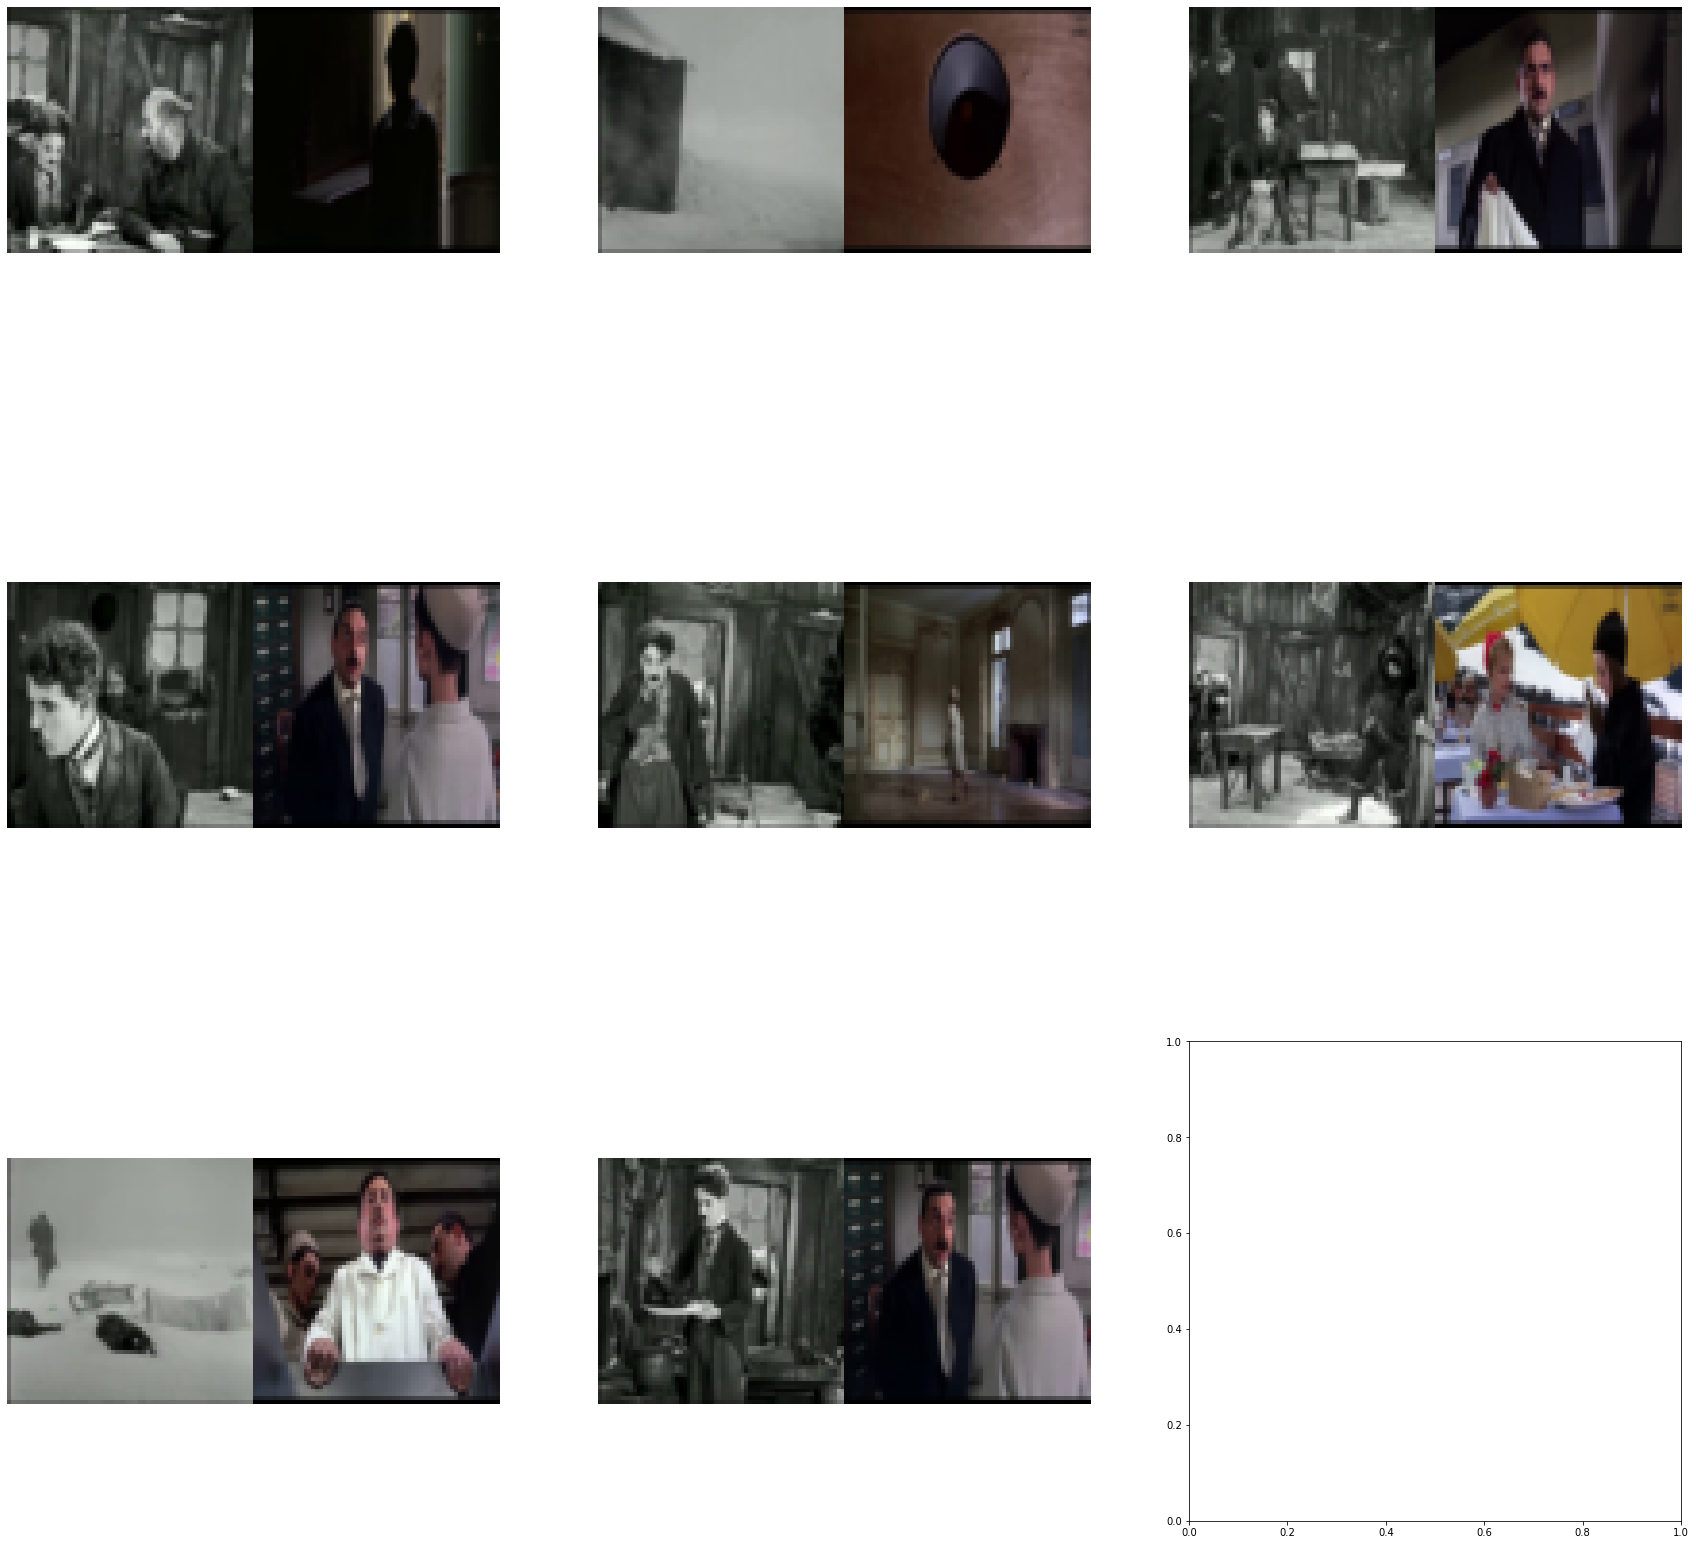

In [ ]:
#hide
show_img2img_batch(data.train_dl)

In [ ]:
#hide
cyclegan = CycleGAN(3,3)
metrics={'Id_Loss':'id_smter.smooth','Gen_Loss':'gen_smter.smooth','Cyc_Loss':'cyc_smter.smooth','Perc_Loss':'perc_smter.smooth','DA_Loss':'da_smter.smooth','DB_Loss':'db_smter.smooth'}

In [ ]:
#hide
norm_zero_point_five = partial(normalize_channel, mean=tensor([0.5,0.5,0.5]).cuda(), std=tensor([0.5,0.5,0.5]).cuda())

In [ ]:
#hide
cbfs = [LR_Find,Recorder, CudaCallback,ProgressbarCallback, CycleGANTrainer, partial(BatchTransformXTupleCallback, norm_zero_point_five)]

In [ ]:
def cyclegan_learner(data, opt_func=lamb_opt(mom=0.5), extra_cbs=None, gen_blocks=9, lr = 1e-2, avg_stats_metrics=None, valid_stats=False, norm=None, lr_find=False, show_imgs=True, plot_hypers=['mom','lr'], lambda_perc=5, perceptual_loss=True, perc_layer_weights=[5,12,2], perc_scale=0.1, display_metrics={},**kwargs):
    cyclegan = CycleGAN(3,3, gen_blocks=gen_blocks)
    metrics={'Id_Loss':'id_smter.smooth','Gen_Loss':'gen_smter.smooth','Cyc_Loss':'cyc_smter.smooth','DA_Loss':'da_smter.smooth','DB_Loss':'db_smter.smooth'}
    if perceptual_loss: metrics['Perc_loss'] = 'perc_smter.smooth'
    for k,v in display_metrics.items():metrics[k] = v
    cbfs = [Recorder, CudaCallback, ProgressbarCallback, CycleGANTrainer]
    if norm: cbfs.append(partial(BatchTransformXTupleCallback, norm))
    if lr_find:
        cbfs.append(LR_Find)
    else:
        if show_imgs:cbfs.append(ShowCycleGANImgsCallback)
        if extra_cbs: cbfs += listify(extra_cbs)
        cbfs.append(partial(AvgStatsCallback,avg_stats_metrics,valid_stats=valid_stats))

    return Learner(cyclegan, data, 
                   CycleGanLossFunc(cyclegan, perceptual_loss = perceptual_loss, lambda_perc=lambda_perc, 
                                    perc_layer_weights=perc_layer_weights, perc_scale=perc_scale), 
                   opt_func = opt_func,cbfuncs = cbfs,lr=lr, metrics=metrics,plot_hypers=plot_hypers, **kwargs)



In [ ]:
#hide
learn = cyclegan_learner(data, norm=norm_zero_point_five, lr_find=True,, perc_scale=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#hide
learn.cbs

In [ ]:
#hide
learn.fit(3)

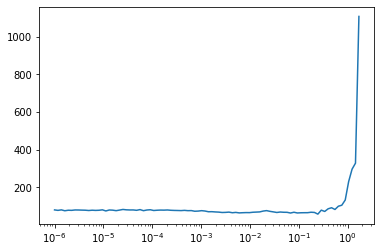

In [ ]:
#hide
learn.recorder.plot()

In [ ]:
#hide
param = sched_1cycle([1e-3],pct_start=0.5, mom_start=0.5,mom_mid=0.35, mom_end=0.5)
learn = cyclegan_learner(data, norm=norm_zero_point_five, perc_scale=0.1)
learn.cbs

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,Id_Loss,Gen_Loss,Cyc_Loss,DA_Loss,DB_Loss,Perc_loss,time
0,15.278677,2.288921,1.772321,4.695750,0.092412,0.073652,5.268876,02:54
1,12.015608,1.489338,1.931983,2.953069,0.034468,0.023285,4.459856,02:54
2,9.748898,1.283215,1.352466,2.242810,0.057093,0.144249,3.841067,02:54
3,7.433908,0.835741,1.066657,1.721739,0.123213,0.134778,3.387989,02:54
4,6.658357,0.722318,1.236625,1.494038,0.095594,0.105012,3.105198,02:54
5,6.312706,0.637837,1.311607,1.339354,0.079446,0.099629,2.902869,02:54
6,6.021721,0.607861,1.301659,1.271446,0.076150,0.097802,2.769616,02:55
7,5.737395,0.566762,1.257765,1.189222,0.072206,0.104859,2.650177,02:54
8,5.500223,0.549214,1.199331,1.125649,0.076975,0.108755,2.552872,02:55
9,5.392679,0.545910,1.187913,1.122057,0.077776,0.113511,2.540095,02:55


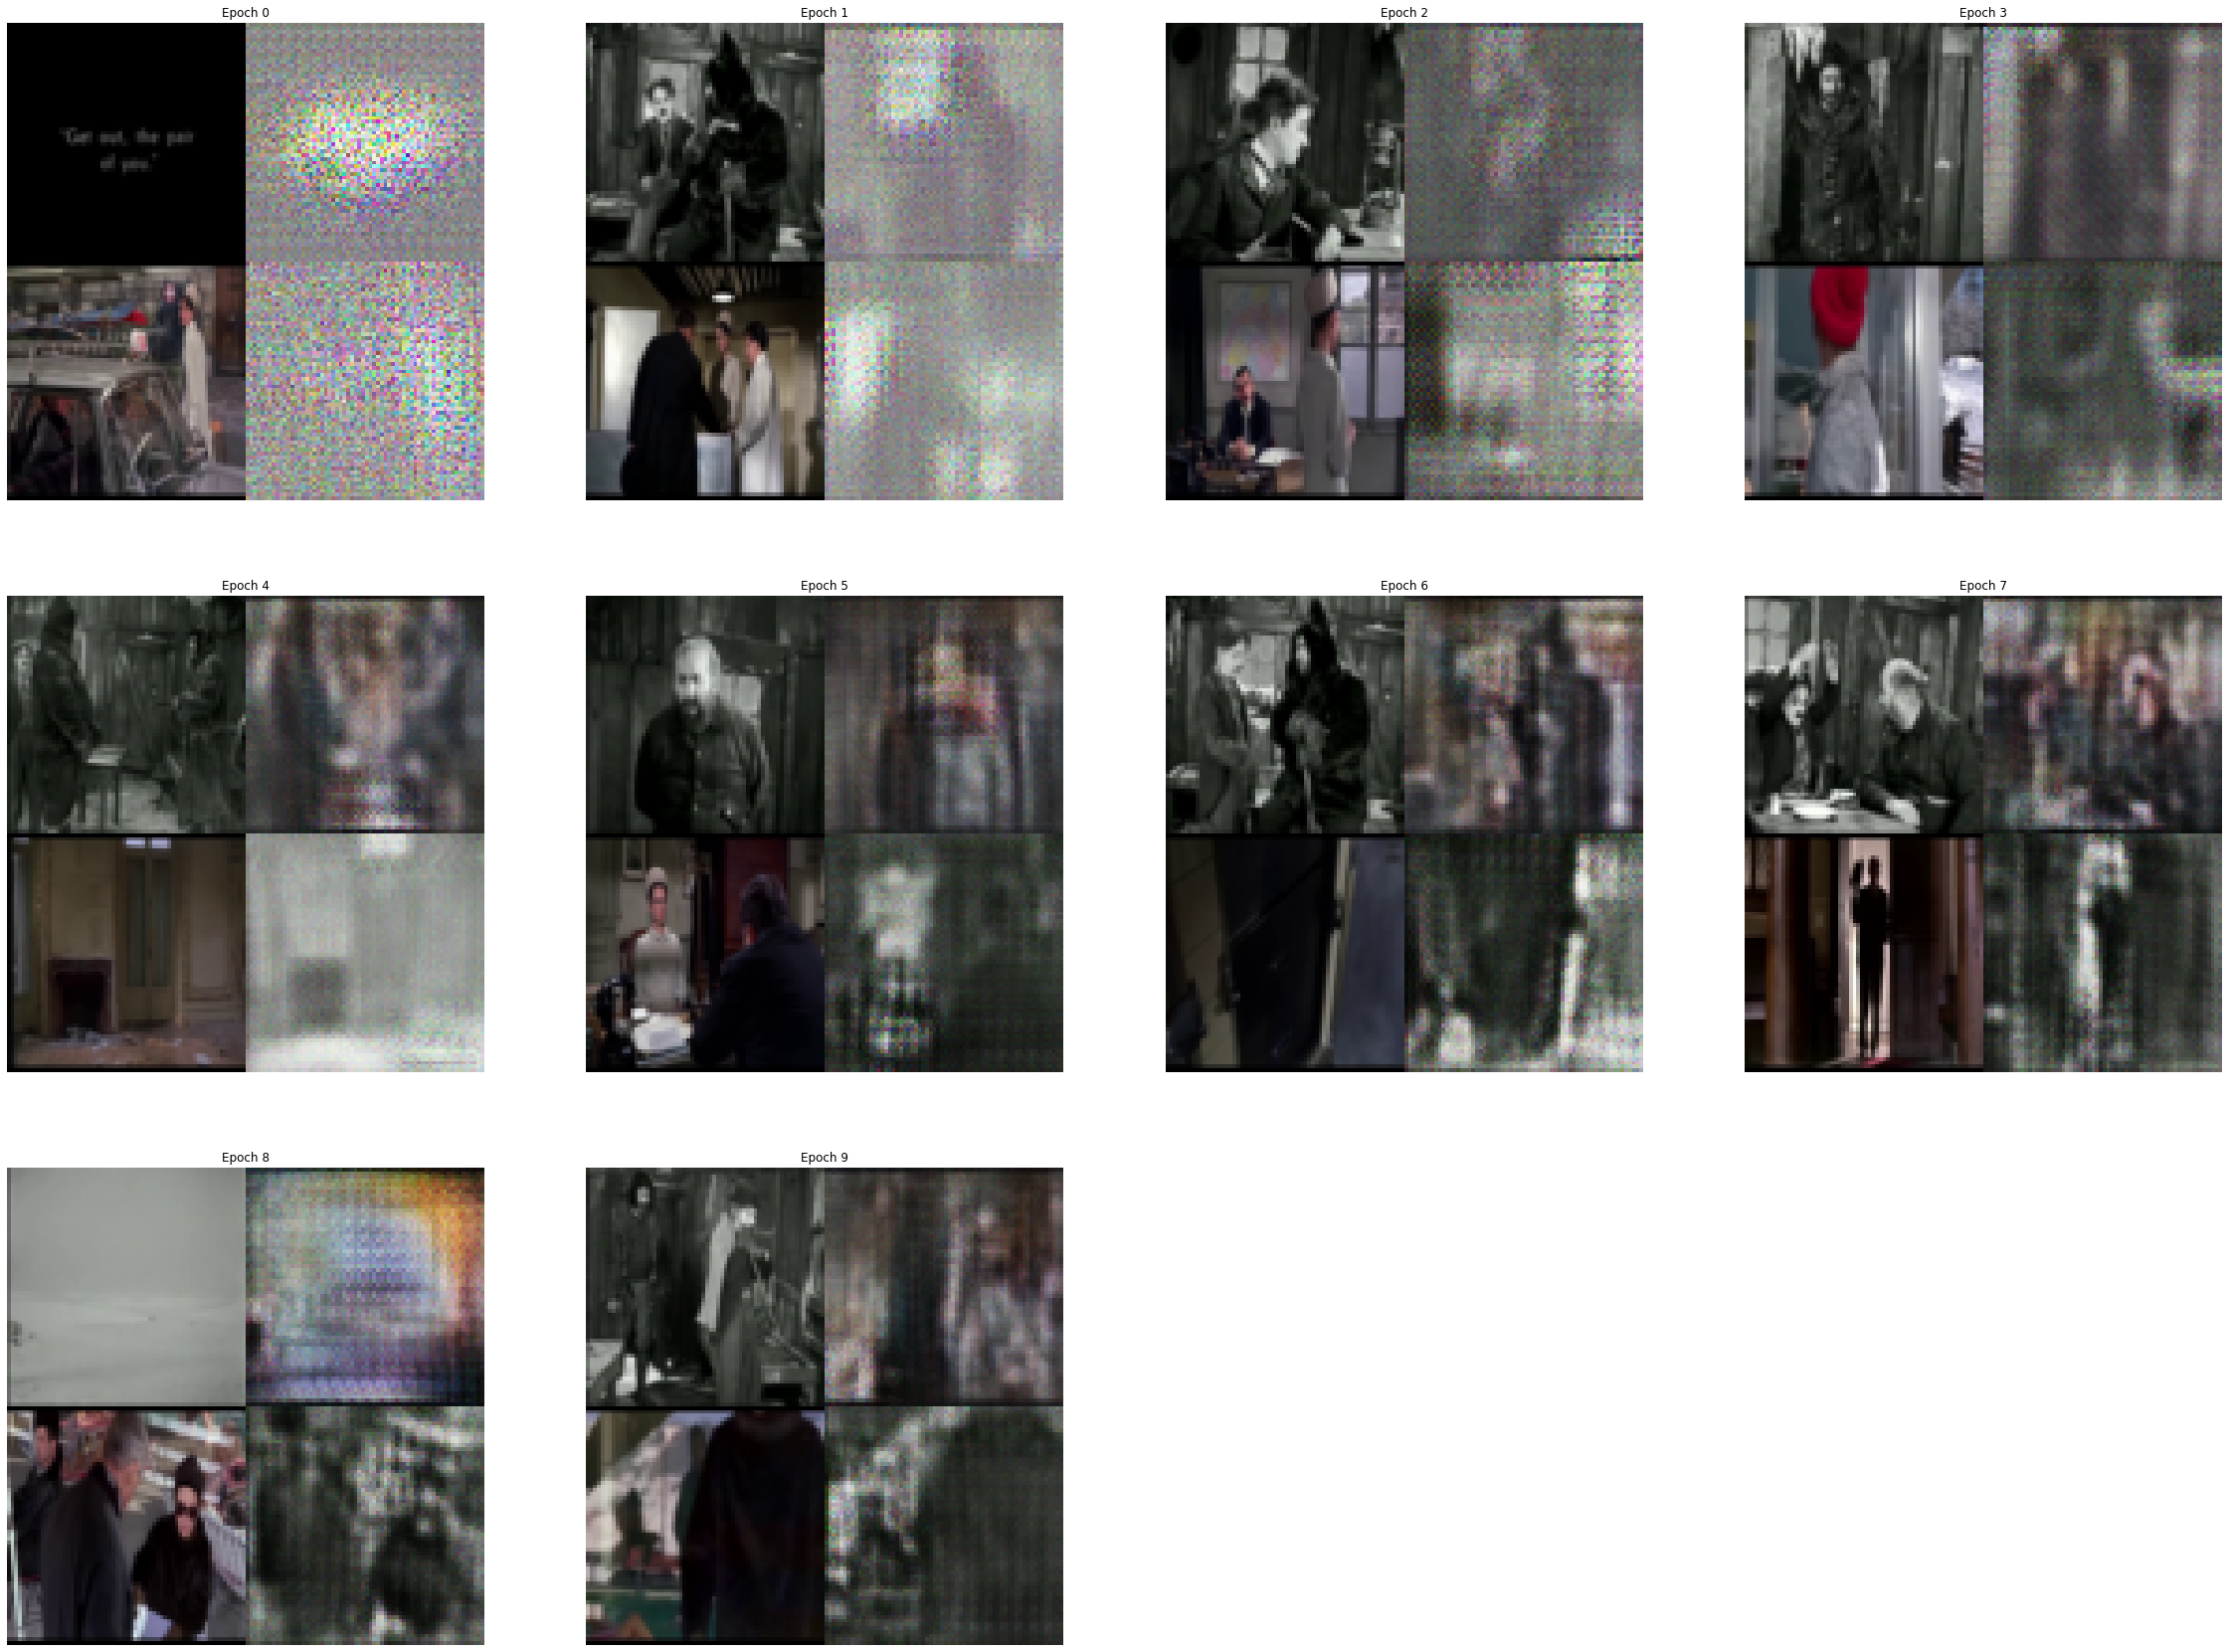

In [ ]:
#hide
learn.fit(10, cbs=param)

In [ ]:
def pretrain_cyclegan_generator(data, opt_func=lamb_opt(mom=0.5), extra_cbs=None, n_blocks = 9, lr = 1e-2, avg_stats_metrics=None, valid_stats=False, norm=None, lr_find=False, show_imgs=True, plot_hypers=['mom','lr'], perc_layer_weights=[5,12,2], perc_scale=1., display_metrics={},**kwargs):
    model = resnet_generator(3,3, n_blocks=n_blocks)

    from torchvision.models import vgg16_bn
    vgg_m = vgg16_bn(True).features.cuda().eval()
    for p in vgg_m.parameters():p.requires_grad_(False)
    blocks = [i-1 for i,o in enumerate(list(vgg_m.children())) if isinstance(o,nn.MaxPool2d)]
    perc_loss = PerceptualLoss(vgg_m, blocks[2:5],perc_layer_weights, scale=perc_scale)
    metrics = {'Perc_loss':'feat_losses'}
    
    for k,v in display_metrics.items():metrics[k] = v
    cbfs = [Recorder, CudaCallback, ProgressbarCallback]
    if norm: cbfs.append(partial(BatchTransformXYCallback, norm))
    if lr_find:
        cbfs.append(LR_Find)
    else:
        if show_imgs:cbfs.append(ShowImgsCallback)
        if extra_cbs: cbfs += listify(extra_cbs)
        cbfs.append(partial(AvgStatsCallback,avg_stats_metrics,valid_stats=valid_stats))

    return Learner(model, data, perc_loss, opt_func=opt_func, cbfuncs = cbfs, metrics=metrics, plot_hypers = plot_hypers, **kwargs)

In [ ]:
#hide
# learn = pretrain_cyclegan_generator(norm=norm_zero_point_five)
learn = pretrain_cyclegan_generator(data ,opt_func=lamb_opt(mom=0.5), norm=norm_zero_point_five,perc_scale=0.1,lr_find=True)

In [ ]:
#hide
learn.fit(3)

KeyboardInterrupt: ignored

In [ ]:
#hide
operator.attrgetter('feat_losses')(learn.loss_func)

tensor(3.2597, device='cuda:0', grad_fn=<MulBackward0>)

In [ ]:
#hide
# learn=None
del learn
import gc
gc.collect()

9600

In [4]:
#hide
!pip install fire
!python dl_lib/notebook2script.py image_colorization/cyclegan/callbacks.ipynb dl_lib/cyclegan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Converted image_colorization/cyclegan/callbacks.ipynb to dl_lib/cyclegan/callbacks.py
